In [5]:
%load_ext autoreload
%autoreload 2

# Deep Gaussian Markov Random Fields

Home-made reimplementation in JAX. Original code can be found [here](https://bitbucket.org/psiden/deepgmrf/src/master/).

In [6]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

from functools import partial
from torch.distributions import MultivariateNormal
import torch
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import optax
from jax_tqdm import scan_tqdm
import copy
import equinox as eqx
import numpy as np


key = jax.random.PRNGKey(0)

In [7]:
try:
    gpu_device = jax.devices('gpu')[0]
except:
    raise RuntimeError("No GPU found")
cpu_device = jax.devices('cpu')[0]
print(cpu_device, gpu_device)

TFRT_CPU_0 cuda:0


## First create some observations
We sample a GMRF with Cholesky sampling

In [8]:
H = 80
W = 80
r = 10


In [9]:
def euclidean_dist(x1, x2, y1, y2):
    return jnp.sqrt((x1 - x2) ** 2 +
                   (y1 - y2) ** 2)

def corr_exp(xy1, xy2, lx, ly, r):
    x1 = xy1 // lx
    y1 = xy1 % lx
    x2 = xy2 // lx
    y2 = xy2 % lx
    return jnp.exp(-euclidean_dist(x1, x2, y1, y2) / r)
    
def fill_diagonal(a, val):
    assert a.ndim >= 2
    i, j = jnp.diag_indices(min(a.shape[-2:]))
    return a.at[..., i, j].set(val)

def cholesky_sampling_gaussian_field(r, source_term, lx, ly):
    '''
    Given the covariance matrix R ((lx*ly,lx*ly)) simulate a
    gaussian random field Y

    The vmapping enables to fill the big covariance matrix quickly
    '''
    iterating = jnp.meshgrid(jnp.arange(lx * ly), jnp.arange(lx * ly))
    iterating = jnp.array([iterating[0].flatten(), iterating[1].flatten()])
    v_ = jax.jit(jax.vmap(corr_exp, (0, 0, None, None, None)))
    cov_mat = v_(iterating[0, :], iterating[1, :], lx, ly, r)
    cov_mat = cov_mat.reshape((lx * ly, lx * ly))
    cov_mat = fill_diagonal(cov_mat, 1.)
    B = jnp.linalg.cholesky(cov_mat)
    

    Y = B @ source_term
    
    Y = Y.reshape((lx, ly))

    return Y

key, subkey = jax.random.split(key)
source_term = jax.random.normal(subkey, shape=(H * W,))

with jax.default_device(cpu_device):
    x_ori = cholesky_sampling_gaussian_field(r, source_term.flatten(), H, W)

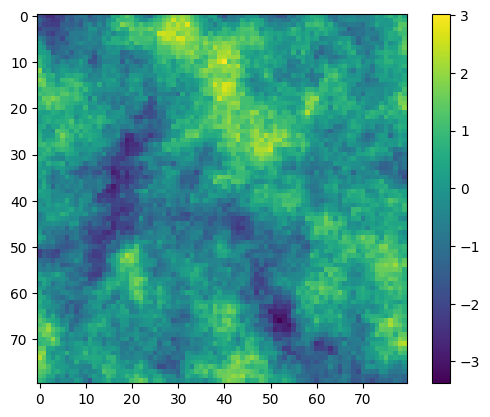

In [10]:
plt.imshow(x_ori)
plt.colorbar()
plt.show()

Add noise over the observations

In [11]:
key, subkey = jax.random.split(key)
true_sigma_noise = 0.2
y = x_ori + jax.random.normal(subkey, x_ori.shape) * true_sigma_noise
M = H * W # no pixel are hidden in the observations
N = H * W

In [12]:
# y = x_ori.at[20:40, 40:60].set(jnp.nan)
# M = H * W - (20 * 20)

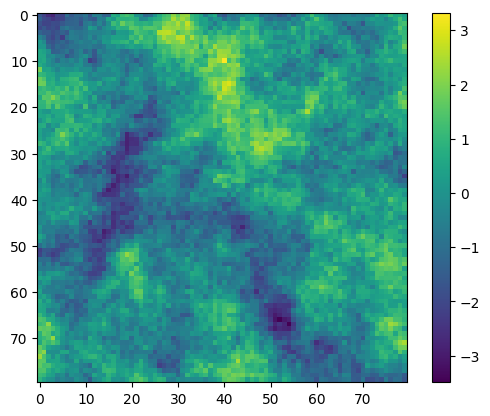

In [13]:
plt.imshow(y)
plt.colorbar()
plt.show()

## Define the DGMRF components

In [18]:
from dgmrf.models import DGMRF
from dgmrf.utils import get_adjacency_matrix_lattice

In [19]:
L = 1
Nq = 10

In [20]:
y = y.flatten()

In [22]:
key, subkey = jax.random.split(key, 2)

dgmrf_conv = DGMRF(subkey, L, height_width=(H, W), init_params=[jnp.array([4., -1, -1, -1, -1, 0.])])

dgmrf_graph = DGMRF(
    subkey,
    L,
    A_D=(get_adjacency_matrix_lattice(H, W), 4 * jnp.eye(H * W, H * W)),
    init_params=[jnp.array([1., -1., 1., 0.])]
)

2.0
1.0
1.0


True


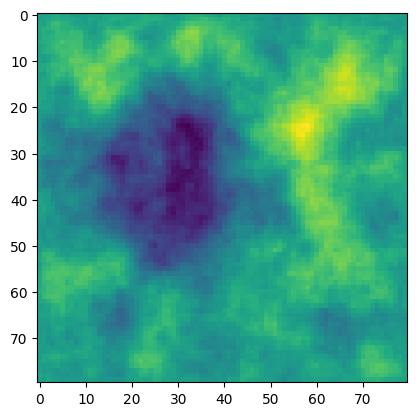

In [23]:
key, subkey = jax.random.split(key, 2)
graph_sample = dgmrf_graph.sample(subkey)
conv_sample = dgmrf_conv.sample(subkey)
print(jnp.allclose(conv_sample, graph_sample))

plt.imshow(conv_sample.reshape(H, W))
plt.show()

In [43]:
dgmrf = DGMRF(subkey, L, height_width=(H, W)) 

dgmrf_params, dgmrf_static = eqx.partition(dgmrf, lambda x:eqx.is_inexact_array(x)) # and not eqx.is_exact because the layer would consider self.key as a parameter!
print(dgmrf_params, dgmrf_static)

NameError: name 'dgmrf' is not defined

## Variational inference to compute model parameters

In [18]:
def elbo(params, static, key):
    
    dgmrf = eqx.combine(params["dgmrf"], static["dgmrf"])

    # Some reparametrizations to avoid numerical errors
    S_phi = jnp.exp(params["log_S_phi"])
    sigma = jnp.exp(params["log_sigma"])
    
    def scan_Nq(carry, nq):
        key = carry[0]
        key, subkey = jax.random.split(key, 2)
        eps = jax.random.normal(subkey, (N,))
        xi = params["nu_phi"] + jnp.sqrt(S_phi) * eps

        g_xi = dgmrf(xi).flatten()
        res = (g_xi.T @ g_xi + 1 / (sigma ** 2) * (y - xi).T @ (y - xi))

        return (key,), res

    _, accu_mcmc = jax.lax.scan(
        scan_Nq,
        (key,),
        jnp.arange(Nq)
    )
    res_mcmc = jnp.mean(accu_mcmc)

    log_det_S_phi = jnp.sum(params["log_S_phi"])
    log_det_G_theta = dgmrf.log_det()
    log_sigma = params["log_sigma"]

    #jax.debug.print("{x}", x=(-log_det_S_phi, log_sigma,-log_det_G_theta, res_mcmc))
    # ELBO divided by N as stated in the supp material
    elbo = 1 / N *  (0.5 * log_det_S_phi - M * log_sigma
             + log_det_G_theta
            - 0.5 * res_mcmc)
    # Note that we return -elbo
    return -elbo

The initial values of the mean and std for the variational distribution are given lines 572 and 573 of the orignal code.

In [19]:
key, subkey1, subkey2 = jax.random.split(key, 3)
params_init = {
    "dgmrf":dgmrf_params,
    "log_sigma":jnp.log(true_sigma_noise),
    "nu_phi":y, #jnp.ones((H * W,)) * jax.random.uniform(subkey1, (H*W,), minval=-3, maxval=3), # * 0.3,
    "log_S_phi":jax.nn.softplus(jax.random.normal(subkey2, (N,)) * 0.01), # jnp.ones((H * W,)) * 1
}
static = {
    "dgmrf": dgmrf_static
}


In [20]:
n_iter = 500

tx = optax.multi_transform(
    {
     'dgmrf': optax.adam(1e-2), 'log_sigma': optax.adam(0),
     'nu_phi': optax.adam(1e-2), 'log_S_phi': optax.adam(1e-2)},
    {'dgmrf':"dgmrf", 'log_sigma':'log_sigma', 'nu_phi':'nu_phi', 'log_S_phi':'log_S_phi'} # This what would be returned by the label_fn; i.e. this is the correct syntax when directly giving labels and when params is dict
)
opt_state = tx.init(params_init)

@scan_tqdm(n_iter)
def scan_fun(carry, i):
    key, params, opt_state = carry
    key, subkey = jax.random.split(key, 2)
    loss, grads = jax.value_and_grad(elbo)(params, static, subkey)
    # #jax.debug.print("{x}",x=(loss))
    updates, opt_state = tx.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return (key, params, opt_state), loss

key, subkey = jax.random.split(key, 2)
carry, loss_val = jax.lax.scan(
    scan_fun,
    (subkey, params_init, opt_state),
    jnp.arange(n_iter)
)
params_final = carry[1]

  0%|          | 0/500 [00:00<?, ?it/s]

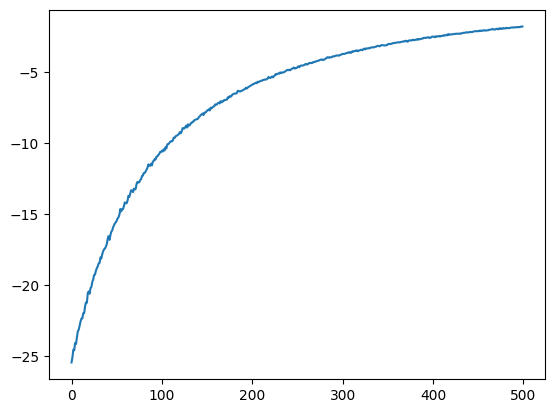

In [21]:
plt.plot(-loss_val)
plt.show()

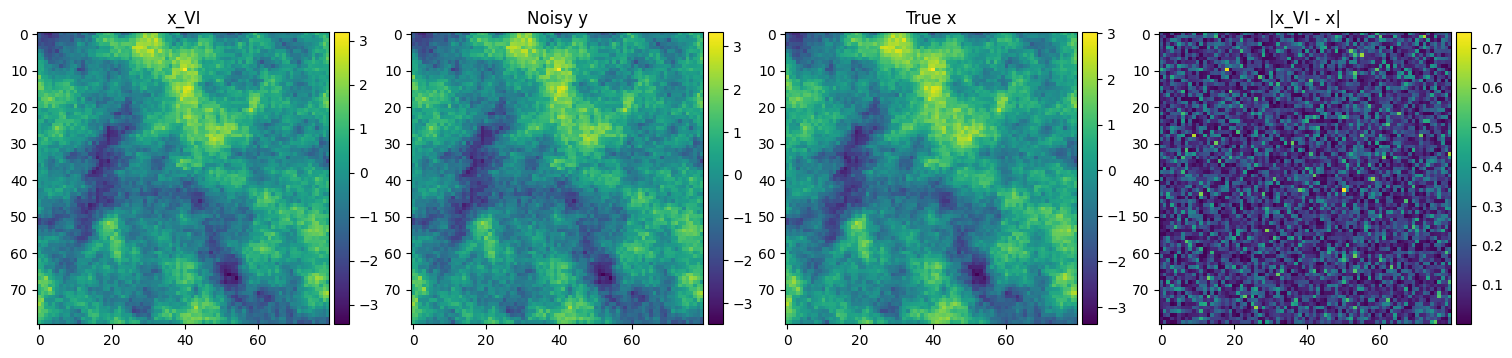

In [22]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(18.5, 10.5)

im = axes[0].imshow(params_final["nu_phi"].reshape(H, W))
axes[0].set_title("x_VI")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(y.reshape(H, W))
axes[1].set_title("Noisy y")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(x_ori)
axes[2].set_title("True x")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[3].imshow(jnp.abs(params_final["nu_phi"].reshape(H, W) - x_ori))
divider = make_axes_locatable(axes[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axes[3].set_title("|x_VI - x|")

plt.show()

## Posterior mean computation with conjugate gradient

We can give $\tilde{Q}$ as a function which tells how to compute $\tilde{Q}x$ that's what we'll do to avoid explicitely constructing $G$ and to be able to use the convolutions 

We observed that CG sampling and CG posterior mean estimation were much affected and much more longer when not given the true observation noise level. That may be why Siden 2018 tells that they do not try to estimate this noise (in Supp. Material). Indeed we observe that when estimating the observation noise level without care, this value deviates a lot from the true value.

In [23]:
print(jnp.log(true_sigma_noise), params_final["log_sigma"])

-1.609438 -1.609438


In [24]:
params_dgmrf_final = copy.deepcopy(params_final["dgmrf"])
log_sigma_final = copy.deepcopy(params_final["log_sigma"]) # 

dgmrf = eqx.combine(params_dgmrf_final, static["dgmrf"])

b0 = dgmrf(jnp.zeros_like(x_ori))

# initial guess for the solution
x0 = params_final["nu_phi"]

In [25]:
def QTilde(x):
    Gx = dgmrf(x.reshape((H, W)))
    GTGx = dgmrf(Gx, transpose=True)
    return GTGx.flatten() + 1 / (jnp.exp(log_sigma_final) ** 2) * x

c = (-dgmrf(b0, transpose=True).flatten() + 1 / (jnp.exp(log_sigma_final) ** 2) * y)

In [26]:
xpost_mean, _ = jax.scipy.sparse.linalg.cg(QTilde, c, x0=x0)

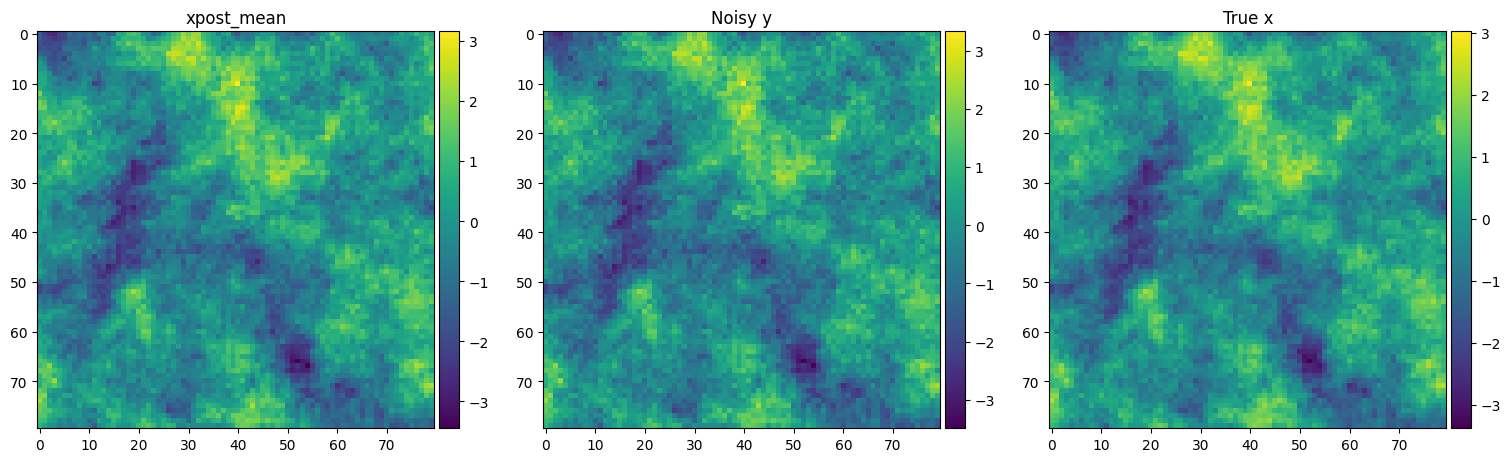

In [27]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)

im = axes[0].imshow(xpost_mean.reshape(H, W))
axes[0].set_title("xpost_mean")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(y.reshape(H, W))
axes[1].set_title("Noisy y")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(x_ori)
axes[2].set_title("True x")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# im = axes[3].imshow(jnp.abs(xpost_mean.reshape(H, W) - x_ori))
# divider = make_axes_locatable(axes[3])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation='vertical')
# axes[3].set_title("|xpost_mean- x|")

plt.show()

## Posterior samples to compute the posterior marginal variances

In [28]:
nb_samples = 50

dgmrf = eqx.combine(params_dgmrf_final, static["dgmrf"])

def posterior_sample(carry, i):
    (key,) = carry
    key, subkey1, subkey2 = jax.random.split(key, 3)
    u1 = jax.random.normal(subkey1, shape=b0.shape)
    u2 = jax.random.normal(subkey2, shape=y.shape)
    c_perturbed = (-dgmrf((u1 - b0), transpose=True).flatten() + 1 / (jnp.exp(log_sigma_final) ** 2) * (y + jnp.exp(log_sigma_final) * u2))
    xpost_CG, _ = jax.scipy.sparse.linalg.cg(QTilde, c_perturbed, x0=x0)
    return (key,), xpost_CG

key, subkey = jax.random.split(key, 2)
_, x_post_samples = jax.lax.scan(
    posterior_sample,
    (subkey,),
    jnp.arange(nb_samples)
)

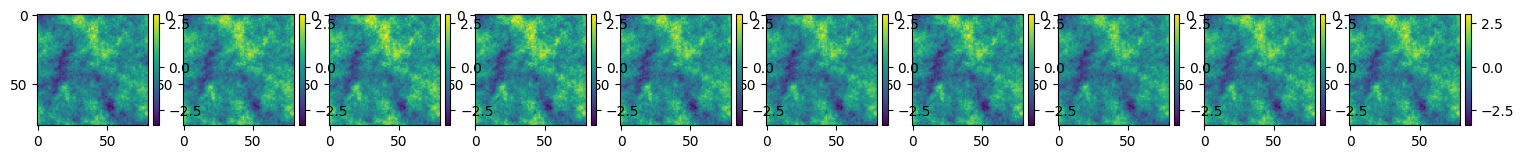

In [29]:
fig, axes = plt.subplots(1, 10)
fig.set_size_inches(18.5, 10.5)

for i, ax in enumerate(axes):
    ax.imshow(x_post_samples[i].reshape(H, W))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

### Simple MC estimator

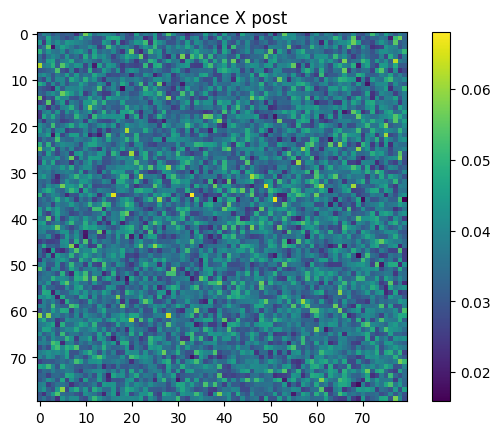

In [30]:
var_x_post_samples = jnp.var(x_post_samples, axis=0)
plt.imshow(var_x_post_samples.reshape(H, W))
plt.title("variance X post")
plt.colorbar()
plt.show()

### Simple Rao-Blackwellized Monte Carlo
From (3.1) in [this article](https://arxiv.org/pdf/1705.08656.pdf). We use a JVP-like way to get $G^TG$ for real. We know that we are only able to compute the matrix vector product $G^TG(x)$. Each time we perform such a computation with $x$ being $0$ everywhere except at one place, we reveal one column of $G^TG$. So we do so repeatedly with a vmap.

In [31]:
x_post_samples_demeaned = x_post_samples - jnp.mean(x_post_samples, axis=0, keepdims=True)
v_QTilde = jax.vmap(QTilde)
diag_QTilde = jnp.diag(v_QTilde(jnp.eye(H * W)))
var_x_post_samples_RBMC = 1 / diag_QTilde + jnp.mean((1 / diag_QTilde * (v_QTilde(x_post_samples_demeaned) - diag_QTilde * x_post_samples_demeaned)) ** 2, axis=0)

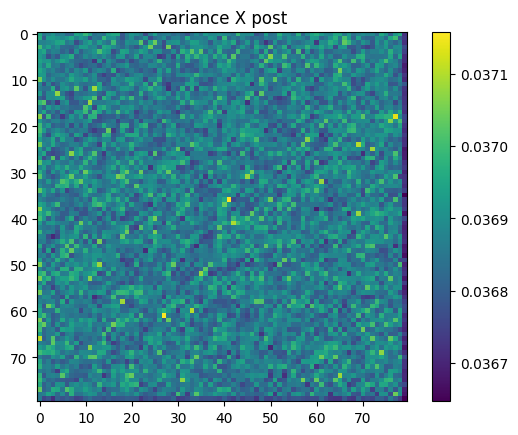

In [32]:
plt.imshow(var_x_post_samples_RBMC.reshape(H, W))
plt.title("variance X post")
plt.colorbar()
plt.show()